In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import TextClassificationPipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Import Data

In [2]:
# Import train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Separate train labels and text
train_labels = train['category']
train_text = train['text']
train_labels_list = train_labels.tolist()

# Separate test labels and text
test_labels = test['category']
test_text = test['text']
test_labels_list = test_labels.tolist()

## Load in Model

In [3]:
# Load in the model
model_id = 'philschmid/BERT-Banking77'
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)
classifier = pipeline('text-classification', tokenizer=tokenizer, model=model, return_all_scores=True)

/Users/wally/anaconda3/envs/INFO4900/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


## Separate out the Errors

In [4]:
# Create a list of all the outputs from the classifier
outputs = []
for text in test_text:
    outputs.append(classifier(text))

In [5]:
errors = []
for x in range(len(outputs)):
    data = outputs[x][0]
    max_score = max(d['score'] for d in data)
    max_label = [d['label'] for d in data if d['score'] == max_score][0]
    if max_label != test_labels_list[x]:
        errors.append(['test_text: ', test_text[x], 'true_label: ', test_labels_list[x], 'predicted_label: ', max_label])

In [6]:
# Visualize errors in data frame
pd.set_option('display.max_rows', 100)
errors_df = pd.DataFrame(errors)
errors_df

,0,1,2,3,4,5
0,test_text:,Is there a way to know when my card will arrive?,true_label:,card_arrival,predicted_label:,card_delivery_estimate
1,test_text:,When will I get my card?,true_label:,card_arrival,predicted_label:,card_delivery_estimate
2,test_text:,How long does a card delivery take?,true_label:,card_arrival,predicted_label:,card_delivery_estimate
3,test_text:,Status of the card I ordered.,true_label:,card_arrival,predicted_label:,lost_or_stolen_card
4,test_text:,How do I know when my card will arrive?,true_label:,card_arrival,predicted_label:,card_delivery_estimate
...,...,...,...,...,...,...
218,test_text:,"I will need to get a new card soon, how do I o...",true_label:,card_about_to_expire,predicted_label:,order_physical_card
219,test_text:,How can I verify my indentity?,true_label:,verify_my_identity,predicted_label:,why_verify_identity
220,test_text:,I need to verify my identity,true_label:,verify_my_identity,predicted_label:,why_verify_identity
221,test_text:,do the details of my profile have to match my ...,true_label:,verify_my_identity,predicted_label:,why_verify_identity


In [7]:
# Print accuracy on test data
print(1-(len(errors_df)/len(test_labels_list)))

0.9275974025974026


## Extracting Logits and Softmax Probabilities

In [8]:
# Output of raw logits (from Mariya's email/stackoverflow code)
class logitFinder(TextClassificationPipeline):
    def postprocess(self, model_outputs):
        best_class = model_outputs["logits"]
        return best_class

classifier = pipeline('text-classification', model=model_id, tokenizer=tokenizer)
type(classifier)

pipe = logitFinder(model = model, tokenizer = tokenizer)
logit_outputs = pipe(test_text.tolist(), batch_size=2, truncation="only_first")

In [9]:
# Convert it into a NumPy array
logits_array = np.array([np.array(logit) for logit in logit_outputs])

# Flatten the logits array to ensure consistent shape
logits_flat = logits_array.reshape(logits_array.shape[0], -1)

# Apply softmax function to logits
softmax_probs = np.exp(logits_flat) / np.sum(np.exp(logits_flat), axis=1, keepdims=True)

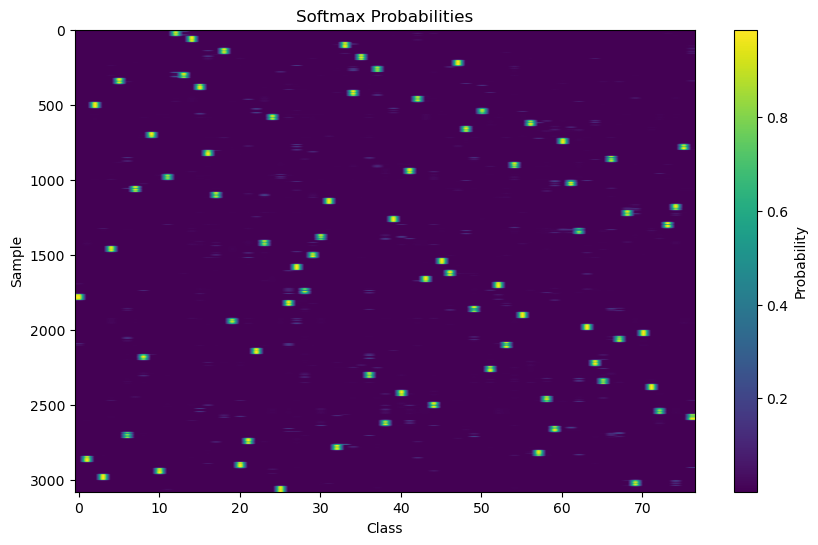

In [10]:
# Visualize Softmaxes
# Apply softmax function to logits
softmax_probs = np.exp(logits_flat) / np.sum(np.exp(logits_flat), axis=1, keepdims=True)

# Define a function to visualize softmax probabilities
def visualize_softmax_probs(softmax_probs):
    # Plotting heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(softmax_probs, cmap='viridis', aspect='auto')
    plt.colorbar(label='Probability')
    plt.xlabel('Class')
    plt.ylabel('Sample')
    plt.title('Softmax Probabilities')
    plt.show()

# Visualize softmax probabilities
visualize_softmax_probs(softmax_probs)

## Implementation of Softmax Prediction Probability from Hendrycks and Gimpel

In [11]:
# Create dataframe of correct predictions

# Elements to exclude
error_text = errors_df[1]

# Create a boolean mask to filter out elements
mask = np.isin(test_text, error_text, invert=True)

# Use the mask to filter elements
correct_predictions = test_text[mask]

#### Find Softmaxes of Correct Predictions

In [12]:
# Get logit outputs
correct_logits = pipe(correct_predictions.tolist(), batch_size=2, truncation="only_first") 

# Convert it into a NumPy array
correct_logits_array = np.array([np.array(logit) for logit in correct_logits])

# Flatten the logits array to ensure consistent shape
correct_logits_flat = correct_logits_array.reshape(correct_logits_array.shape[0], -1)

# Apply softmax function to logits
correct_softmax_probs = np.exp(correct_logits_flat) / np.sum(np.exp(correct_logits_flat), axis=1, keepdims=True)

#### Find Softmaxes of Erroneous Predictions

In [13]:
# Get logit outputs
erroneous_logits = pipe(error_text.tolist(), batch_size=2, truncation="only_first") 

# Convert it into a NumPy array
erroneous_logits_array = np.array([np.array(logit) for logit in erroneous_logits])

# Flatten the logits array to ensure consistent shape
erroneous_logits_flat = erroneous_logits_array.reshape(erroneous_logits_array.shape[0], -1)

# Apply softmax function to logits
erroneous_softmax_probs = np.exp(erroneous_logits_flat) / np.sum(np.exp(erroneous_logits_flat), axis=1, keepdims=True)

#### Comparing Softmaxes of Correct and Erroneous

In [21]:
# Find mean of maximum values for each correct softmax calculation
comb_correct_max_vals = []
for label in correct_softmax_probs:
    max_val = max(label)
    comb_correct_max_vals.append(max_val)

print(np.mean(comb_max_vals))


0.9472402


In [22]:
# Find mean of maximum values for each erroneous softmax calculation
comb_erroneous_max_vals = []
for label in erroneous_softmax_probs:
    max_val = max(label)
    comb_erroneous_max_vals.append(max_val)

print(np.mean(comb_erroneous_max_vals))

0.6872993
